# `AA Workshop 08` - Probabilistic Classification & Non-Linear Features

In this workshop we will continue our discussion of classification. Last week we introduced basic linear classification and evaluation of classifiers, this week we will dive into probabilistic classification and using non-linear features.

We will cover the following: 
1. Logistic Regression
1. Naive Bayes
1. Non-Linear Features
1. Exemplary Model Development Routine

---

## Recap: Breast Cancer Classification

To introduce classification problems, we're going to continue with the example of identifying whether cancer cells from a biopsy are malignant or benign.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

np.set_printoptions(suppress=True) # suppress scientific notation
%matplotlib inline

In [2]:
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
print("Number of benign samples:", len(cancer_df[cancer_df["diagnosis"]=="B"]))
print("Number of malignant samples:", len(cancer_df[cancer_df["diagnosis"]=="M"]))

Number of benign samples: 357
Number of malignant samples: 212


In [3]:
cancer_df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


---

## Logistic Regression

Logistic regression results from choosing the logistic loss
\begin{equation}
\ell_{\mathrm{logistic}}(h_\theta(x), y) = \log(1+\exp(-h_\theta(x) \cdot y))
\end{equation}
as our classification loss to minimize.  Logistic regression also has a nice probabilistic interpretation: certain quantities give the _probability_, under a particular model, of an example being positive or negative. We will consider this probabilistic setting later, but for now we are going to simply treat it as another loss minimization algorithm.

Assuming a linear hypothesis function (the typical assumption under logistic regression), the partial deriative of the logistic loss is given by
\begin{equation}
\begin{split}
\frac{\partial}{\partial \theta_j} \log(1+\exp(-\theta^T x \cdot y)) & = \frac{1}{1+\exp(-\theta^T x \cdot y)} \frac{\partial}{\partial \theta_j} (1+\exp(-\theta^T x \cdot y))\\  
& = - \frac{\exp(-\theta^T x \cdot y)}{1+\exp(-\theta^T x \cdot y)} x_j\cdot y \\
& = -\frac{1}{1+\exp(\theta^T x \cdot y)} x_j\cdot y
\end{split}
\end{equation}
where in the last line we use the fact that
\begin{equation}
\frac{\exp(-x)}{1+\exp(-x)} = \frac{\exp(-x)}{1+\exp(-x)} \cdot \frac{\exp(x)}{\exp(x)} = \frac{1}{1+\exp(x)}
\end{equation}


Thus, the gradient of the entire objective function for logistic regression (we'll omit any regularization term, though we could also add this if desired) is given by

\begin{equation}
\begin{split}
\nabla_\theta E(\theta) & = 
\nabla_\theta \frac{1}{m} \sum_{i=1}^m \log \left (1+ \exp \left (\theta^T x^{(i)} \cdot y^{(i)} \right )\right) \\
& = \frac{1}{m} \sum_{i=1}^m -x^{(i)} y^{(i)} \frac{1}{1+\exp\left(\theta^T x^{(i)} \cdot y^{(i)}\right)}.
\end{split}
\end{equation}

We can use this derivation to write the gradient descent procedure for logistic regression.

For the purpose of this exercise, however, we will use the readily available `LogisticRegression` class in scikit learn.

### One Predictor

Let's first use `area_mean` as the single predictor.

**Remember**: make sure to standardize your input features using the `StandarScaler` class in scikit learn. This should be the default approach in any classification setting! The `StandarScaler` has a similar interface as the machine learning classes, where you first initialize, then use `.fit()` (which computes the mean and variance of a column), and `.transform()` (which converts the data to have zero mean and unit variance). `StandardScaler` standardizes to 0 mean and unit variance. Also note that we do not actually have to re-scale our target variable; LogisticRegression can handle the labels as they are.

In [4]:
# define x and y
x = cancer_df['area_mean'].values.reshape(-1,1)
y = cancer_df['diagnosis']

# standardize x
from sklearn.preprocessing import StandardScaler

norm = StandardScaler() # initialize
X_norm = norm.fit_transform(x)  # simultaneously fit and transform

In [5]:
# define helper functions for plotting
def rescale_classes(class_membership, true_label='M'):
    return (class_membership == true_label).astype(int) * 2 - 1

def plot_cells(variable='area_mean'):
    plt.figure(figsize=(8,6))
    malign = cancer_df[cancer_df["diagnosis"]=="M"]
    benign = cancer_df[cancer_df["diagnosis"]=="B"]
    plt.scatter(benign[variable], rescale_classes(benign['diagnosis']), marker='x', color='orange')
    plt.scatter(malign[variable], rescale_classes(malign['diagnosis']), marker='x', color='red')
    plt.plot([0, 2600], [0,0], color='lightgrey', linestyle='dotted')
    plt.xlim([0,2600])
    plt.ylim([-1.1,1.1])
    plt.xlabel("Mean Area")
    plt.ylabel("Class")

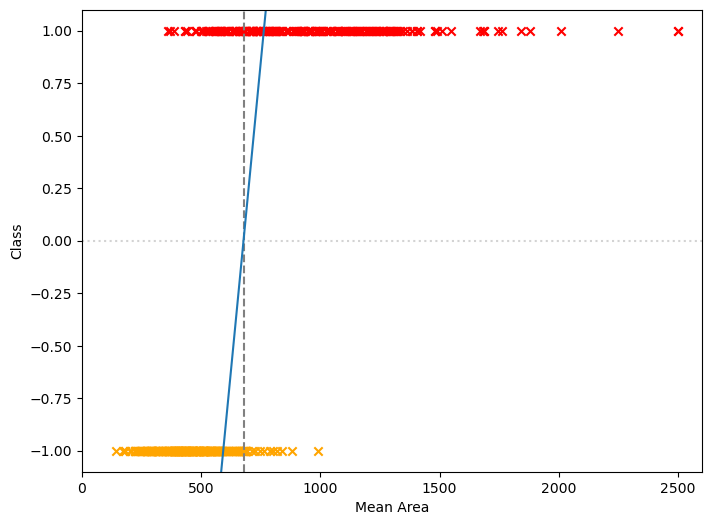

In [6]:
from sklearn.linear_model import LogisticRegression

# fit model
model_log_one = LogisticRegression(C=100)   # C is a regularization term, we set it to 100 here
model_log_one.fit(X_norm, y)

# plot
plot_cells()
xfit = np.linspace(0, 2600)
xfit_scaled = norm.transform(xfit.reshape(-1,1))
plt.plot([680, 680], [-1.1, 1.1], color='grey', linestyle='--')
plt.plot(xfit, model_log_one.decision_function(xfit_scaled.reshape(-1,1)))
plt.show()

Note that in the graph above, we plotted the raw outputs from our hypothesis function using the `decision_function`-method. The `predict`-method, on the other hand, gives us the predicted class labels:

In [7]:
# print the first 10 outputs of the decision_function-method
model_log_one.decision_function(X_norm)[:10].reshape(-1,1)

array([[ 3.79873298],
       [ 7.61754716],
       [ 6.17227287],
       [-3.42646343],
       [ 7.27679143],
       [-2.35719547],
       [ 4.25699069],
       [-1.17277556],
       [-1.85546203],
       [-2.3712957 ]])

In [8]:
# print corresponding predictions using predict-method
predictions = model_log_one.predict(X_norm)
predictions[:10].reshape(-1,1) # print first 10 predictions

array([['M'],
       ['M'],
       ['M'],
       ['B'],
       ['M'],
       ['B'],
       ['M'],
       ['B'],
       ['B'],
       ['B']], dtype=object)

One of the nice properties of a logistic regression is the possibility to return not only the raw predictions (from the hypothesis function) or the predicted class labels (using the predict-method), but we can also return the predicted probabilities of belonging to a class using the `predict_proba`-method:

In [9]:
print("Order of classes:", model_log_one.classes_)
model_log_one.predict_proba(X_norm)[:10] # return predicted probabilities for first 10 observations

Order of classes: ['B' 'M']


array([[2.19084046e-02, 9.78091595e-01],
       [4.91504833e-04, 9.99508495e-01],
       [2.08214392e-03, 9.97917856e-01],
       [9.68521425e-01, 3.14785754e-02],
       [6.90922708e-04, 9.99309077e-01],
       [9.13504465e-01, 8.64955353e-02],
       [1.39670239e-02, 9.86032976e-01],
       [7.63646345e-01, 2.36353655e-01],
       [8.64767134e-01, 1.35232866e-01],
       [9.14612105e-01, 8.53878948e-02]])

Make sure to understand how the outputs from `decision_function`, `predict` and `predict_proba` interrelate.

**Background on probabilities:** how does a logistic regression generate these probabilities? The key is a simple transformation of our linear hypothesis function. Remember that our hypothesis function $h_\theta(x)$ is just a linear combination of our input features and their respective coefficients. The resulting values are represented by the blue line in the plot above. The output from our linear hypothesis function is unbounded, meaning that predicted values can theoretically vary from very positive to very negative numbers. Since we are predicting only two classes, this is not ideal. Instead, what we really want are predictions that are restricted to a range of 0 and 1 - which would enable interpreting the predictions as probabilities. The sigmoid transformation, defined as $1/(1+e^{-h_\theta(x)})$ does exactly that. We can visualize this using our plot above, but changing the scale of our y-axis to 0 and 1 instead of -1 and 1:

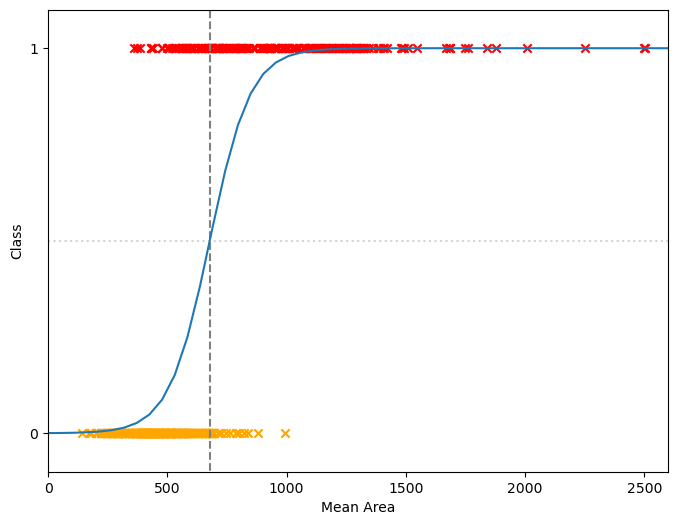

In [10]:
plt.figure(figsize=(8,6))
malign = cancer_df[cancer_df["diagnosis"]=="M"]
benign = cancer_df[cancer_df["diagnosis"]=="B"]
plt.scatter(benign['area_mean'], benign['diagnosis'], marker='x', color='orange')
plt.scatter(malign['area_mean'], malign['diagnosis'], marker='x', color='red')
plt.plot([0, 2600], [0.5,0.5], color='lightgrey', linestyle='dotted')
plt.xlim([0,2600])
plt.ylim([-0.1,1.1])
plt.xlabel("Mean Area")
plt.ylabel("Class")
plt.yticks(ticks = [0,1], labels=[0,1])
xfit = np.linspace(0, 2600)
xfit_scaled = norm.transform(xfit.reshape(-1,1))
plt.plot([680, 680], [-1.1, 1.1], color='grey', linestyle='--')
plt.plot(xfit, model_log_one.predict_proba(xfit_scaled.reshape(-1,1))[:,1])
plt.show()

In the plot above, the blue curve illustrates the probability of belonging to class "malignant".

### Two Predictors

Let's include a second predictor, namely `concave points_mean`.

In [11]:
# helper function for plotting
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),  # create coordinate mesh
                        np.linspace(y_range[0], y_range[1], grid))
    
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C0')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C3')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant', 'Benign'])

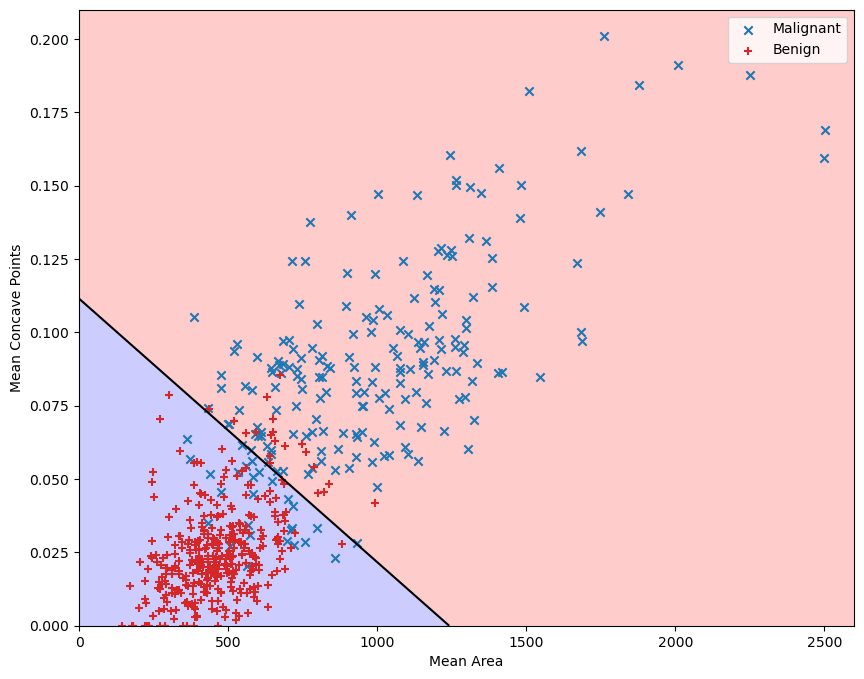

In [12]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

model_log_two = LogisticRegression(C=1e2)   # C is a regularization term, we set it to 100 here
model_log_two.fit(X_norm, Y)

plot_classification_sklearn(model_log_two, norm)

How well does our model perform (on the training dataset)? Let us look at the accuracy.

In [13]:
print((model_log_two.predict(X_norm) == Y).mean())  # Note: mean() operation on booleans returns the proportion of True

# alternatively:
from sklearn.metrics import accuracy_score
acc = accuracy_score(Y, model_log_two.predict(X_norm))
print(acc)

0.9191564147627417
0.9191564147627417


### All Predictors

In the example above we used just two features to classify cancer cells. We achieved a decent accuracy of >90%. Can we impove performance even further by including more information, i.e. more features?

In [14]:
# inspect available features
cancer_df.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [15]:
X_full = np.array(cancer_df[['radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']])

Y = cancer_df['diagnosis'].values

# transform
norm_full = StandardScaler()
X_norm_full = norm_full.fit_transform(X_full)

In [16]:
# train new model
model_log_full = LogisticRegression(C=1e2)
model_log_full.fit(X_norm_full,Y)

# return acuracy
print((model_log_full.predict(X_norm_full) == Y).mean())

0.9929701230228472


---

## Naive Bayes

Naive Bayes is a machine learning algorithm that rests heavily on probabilistic modeling, particularly Bayes’ Theorem. In contrast to Bayes' Theorem, we make the "naive" assumption that all features are conditionally independent given the class. As a result, we estimate class probabilities as

\begin{equation}
p(y \mid X) = \frac{p(X \mid y) \, p(y)}{p(X)} = \frac{\prod_i p(x_i \mid y) p(y)}{\prod_i p(x_i)}
\end{equation}

To estimate $p(x_i \mid y)$, Naive Bayes makes assumptions about the underlying distribution for each $x_i$ within each class $y$. The most commonly assumed distribution for numerical features is the Gaussian distribution, which is implemented in the Gaussian Naive Bayes algorithm `GaussianNB` in sklearn. We will illustrate this using our example with the two numerical features `area_mean` and `concave points_mean`.

Note that since Naive Bayes looks at the distribution of each feature separately within each class, it is typically not required to standardize features beforehand.

In [17]:
X = np.array(cancer_df[['area_mean','concave points_mean']])
Y = cancer_df['diagnosis'].values

As we can see in the plotted histograms of our two features by class, the Gaussian assumption seems reasonable in our case.

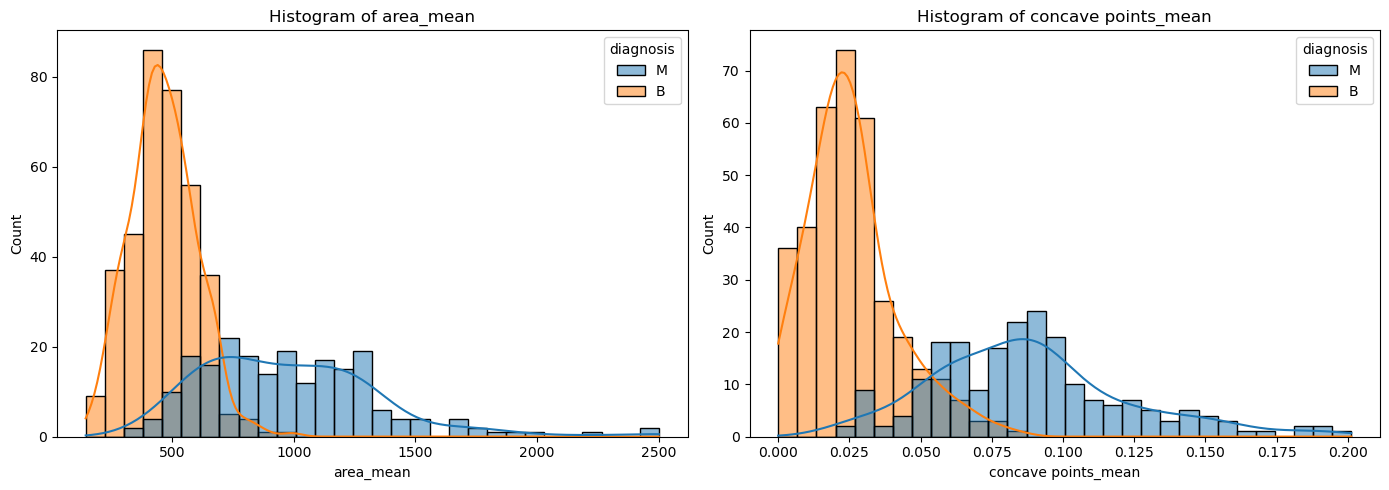

In [18]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
sns.histplot(data=cancer_df, x='area_mean', hue="diagnosis", kde=True, bins=30, alpha=0.5)
plt.title(f"Histogram of area_mean")

plt.subplot(1, 2, 2)
sns.histplot(data=cancer_df, x='concave points_mean', hue="diagnosis", kde=True, bins=30, alpha=0.5)
plt.title(f"Histogram of concave points_mean")

plt.tight_layout()
plt.show()

In [19]:
from sklearn.naive_bayes import GaussianNB

# train model
model_gnb = GaussianNB()
model_gnb.fit(X, Y)

,priors,None
,var_smoothing,1e-09


In [20]:
# evaluate performance (on training data)
print((model_gnb.predict(X) == Y).mean())  # Note: mean() operation on booleans returns the proportion of True

0.9015817223198594


**IMPORTANT**: keep in mind that `GaussianNB` assumes a Gaussian distribution and is, therefore, only suitable for numerical features. If you have categorical predictors, you need to use models that assume different underlying distributions (such as `BernoulliNB` or `CategoricalNB`). Please refer to the [sklearn documentation](scikit-learn.org/stable/modules/naive_bayes.html) for all available alternatives.

---

## Classification with Non-Linear Features

Remember that when discussing linear regression a couple of weeks ago, we tried to predict peak electricity demand using peak temperature. Eventually, we did not only include peak temperature, but instead generated additional features from this raw input using polynomials or RBFs. You guessed it, we can do exactly the same for classification. 

Just like for linear vs. non-linear regression, the application to the classification setting is just a matter of plugging in the relevant features into our classification algorithms.

Let's begin by considering again our example of the breast cancer cell classification task, loading the data and running a linear SVM on the two-feature reduced example. Note how we already use the polynomial features method for that, using degree one.


In [21]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler

In [22]:
from sklearn.svm import LinearSVC # Linear Support Vector Classifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score

In [23]:
norm = StandardScaler()
X_norm = norm.fit_transform(X)  # simultaneously fit and transform 

In [24]:
def poly_feat_sklearn (X, deg):
    model = PolynomialFeatures(deg)
    X = model.fit_transform(X)
    return X

In [25]:
def plot_classification_sklearn_non_lin(model, norm, deg):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=200
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))  # create coordinate mesh
    
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(poly_feat_sklearn(norm.transform(X_),deg)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')

    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant','Benign'])

0.9156414762741653


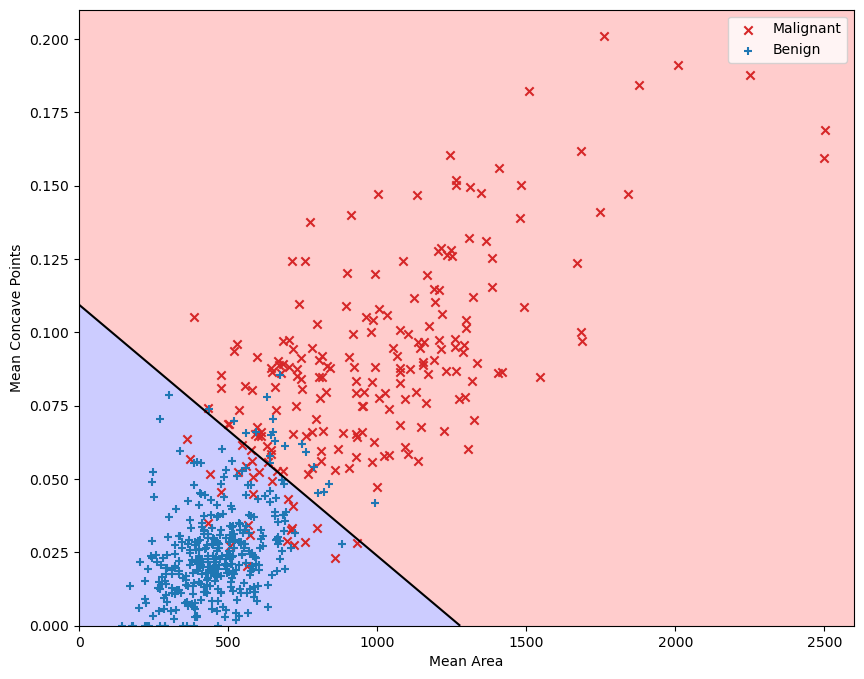

In [26]:
deg=1
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9103690685413005


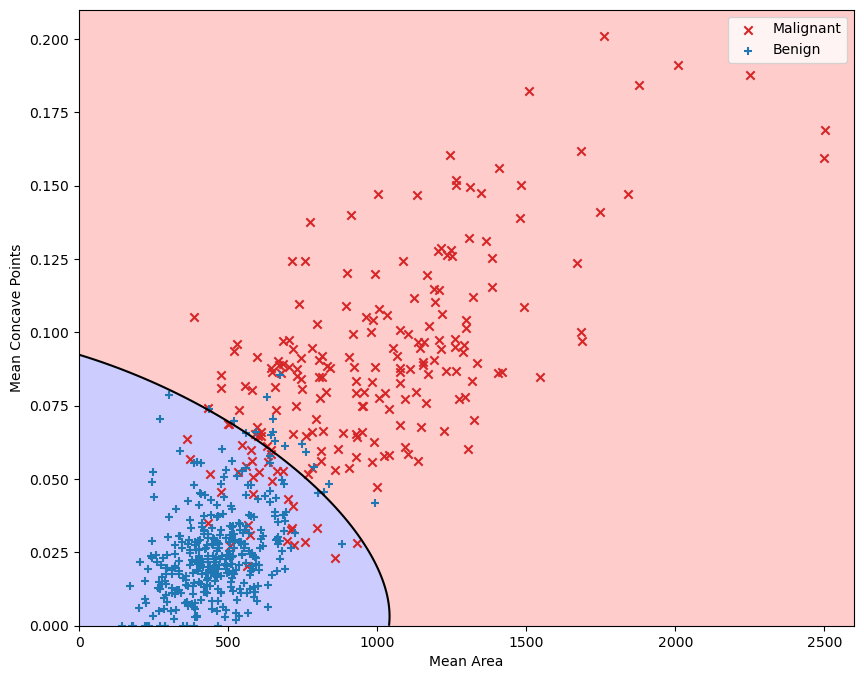

In [27]:
deg=2
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9173989455184535


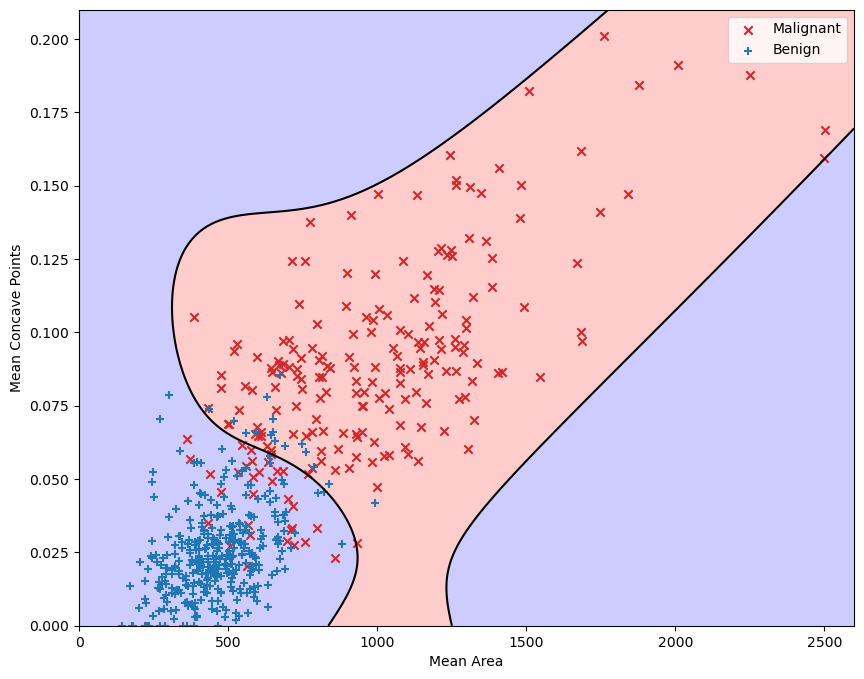

In [28]:
deg=4
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

0.9156414762741653


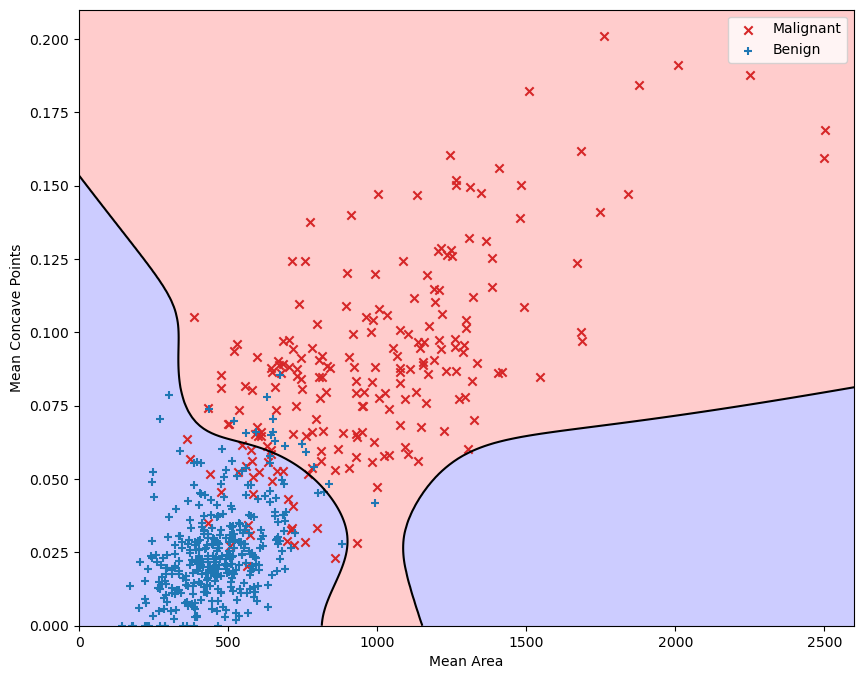

In [29]:
deg=8
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

At this point, just like with the regression examples we saw, the model is probably starting to overfit.  And just like before, we can counteract this to some extent by increasing the regularization parameters (or in scikit learn's terminology, decreasing the $C$ parameter).

0.8945518453427065


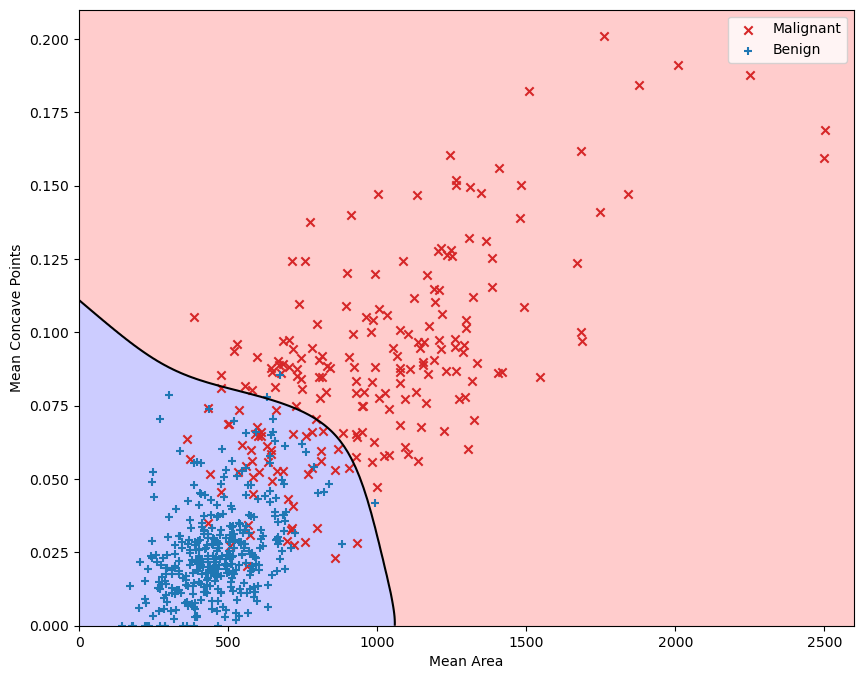

In [30]:
deg=8
Phi = poly_feat_sklearn(X_norm, deg)
model_SVM_poly = LinearSVC(loss='hinge',max_iter=100000, C=0.01)
model_SVM_poly.fit(Phi, Y)
plot_classification_sklearn_non_lin(model_SVM_poly, norm, deg)
print(accuracy_score(Y,model_SVM_poly.predict(Phi)))

Scikit-Learn actually contains a more general implementation of SVM classification (`SVC`; before we were using `LinearSVC`), which allows us to freely use other types of feature relationships, employing a so-called kernel (linear, RBF, poly, etc.). Let's have a look and let us consider some kernel-based functions. Note that in addition to adding the `degree=d` parameter, you'll want to set the `coef0=1.0` parameter to include the constant term `1` in the kernel function (without this, the polynomial kernel only has terms of degree _exactly_ $d$, and typically performs quite poorly).

### Polynomial Kernel

In [31]:
def plot_classification_sklearn(model, norm):
    x_range = [0,2600]
    y_range = [0, 0.21]
    plt.figure(figsize = (10,8))
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
    plt.contour(cs, colors='k')
    
    # plot data points
    s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M']['area_mean'], cancer_df[cancer_df["diagnosis"]=='M']['concave points_mean'], marker='x', color='C3')
    s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B']['area_mean'], cancer_df[cancer_df["diagnosis"]=='B']['concave points_mean'], marker='+', color='C0')    
    plt.xlim([0,2600])
    plt.ylim([0,0.21])
    plt.xlabel("Mean Area")
    plt.ylabel("Mean Concave Points")
    plt.legend([s1,s2],['Malignant','Benign'])

0.9121265377855887


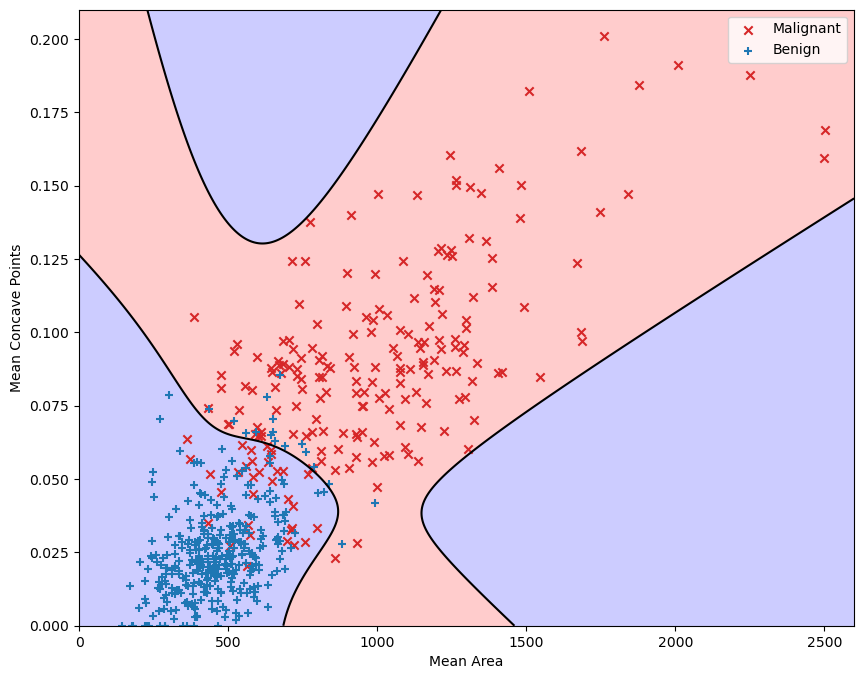

In [32]:
from sklearn.svm import SVC

deg=4
model = SVC(kernel='poly', C=100, degree=deg, coef0=1.0)
model.fit(X_norm, Y)
plot_classification_sklearn(model, norm)
print(accuracy_score(Y,model.predict(X_norm)))

### Radial basis function (RBF)

If I were to make a completely anecdotal estimate, I would guess that the most frequently used type of nonlinear feature is not the polynomial, but something called the _radial basis function_, often abreviated as RBF.  Radial basis functions are similar to polynomials in that they are non-linear functions of the input data, but they are notably different in that they are generally _local_ features: the value of any particular feature is close to zero for most of the input space, but non-zero in a small region around a "center" parameter.  Let's start with the definition, and we can then provide some illustrations that hopefully make this more concrete.  To keep things simple at the start, we're only going to consider radial basis functions of one-dimensional raw inputs.  A radial basis function feature vector is defined as the following:
$$
\phi : \mathbb{R} \rightarrow \mathbf{R}^k = \left[ \begin{array}{c} 
\exp \left(\frac{-(x - \mu^{(1)})^2}{2\sigma^2} \right) \\
\exp \left(\frac{-(x - \mu^{(2)})^2}{2\sigma^2} \right) \\
\vdots \\
\exp \left(\frac{-(x - \mu_{(k-1)})^2}{2\sigma^2} \right) \\
1
\end{array} \right]
$$




where $\mu^{(1)},\ldots,\mu^{(k-1)} \in \mathbb{R}$ (called the means) and $\sigma \in \mathbb{R}$ (called the bandwidth) are the hyperparameters of this feature vector.  

Let's look at a single one of these terms $\phi_j(x)$ (this is the $j$th element of the feature vector, because remember $\phi(x)$ outputs a $k$-dimensional vector).
\begin{equation}
\phi_j(x) = \exp \left(\frac{-(x - \mu^{(j)})^2}{2\sigma^2} \right)
\end{equation}
If you're familiar with the Gaussian distribution, you may recognize this as looking similar to the density function of the Gaussian (though without the normalizing constant). One single dimension of this feature (for varying inputs $x$, and here assuming mean $\mu^{(j)} = 1.5$ and $\sigma = 0.4$) looks like the following:

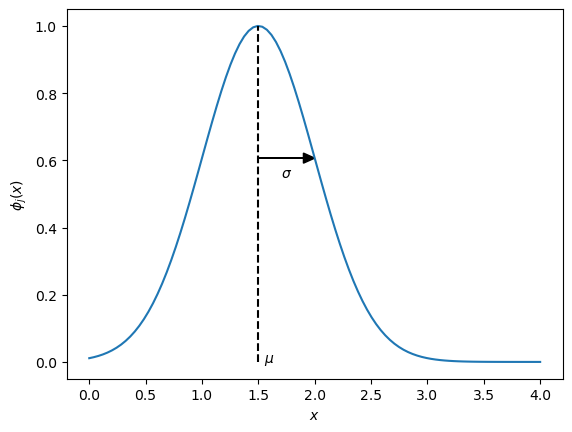

In [33]:
x = np.linspace(0,4,100)
mu_j = 1.5
sigma = 0.5
plt.plot(x,np.exp(-(x-mu_j)**2 / (2*sigma**2)))
plt.plot([1.5,1.5], [0,1], 'k--')
plt.text(1.55, 0, r"$\mu$")
plt.arrow(1.5, np.exp(-0.5), 0.5-0.1, 0, head_width=0.03, head_length=0.1, fc='k')
plt.text(1.7, 0.55, r"$\sigma$")
plt.xlabel("$x$")
plt.ylabel(r"$\phi_j(x)$")
plt.show()

The feature is largest (equal to one) when $x$ is equal to $\mu$, but falls off very rapidly as $x$ moves away from $\mu$ (proportional to the exponential of the negative squared difference, which will go effectively towards zero very quickly). Those who are familiar with Gaussian densities will notice the familiar formula and bell-shaped curve, where about two thirds of the area under the curve lies within $\sigma$ of the center. Note, however, that despite superficial similarities, this is _not_ a Gaussian distribution: it is not scaled, and the maximum value for any specific feature is always 1.0 for $x = \mu_j$. To emphasize this difference further, some definitions of RBFs define them just in terms of a different scaling parameter instead of the bandwidth
\begin{equation}
\phi_j(x) = \exp(-\gamma (x-\mu^{(j)})^2)
\end{equation}
which, of course, is equivalent to the above if we set $\gamma = 1/(2\sigma^2)$. However, it's a bit more common to see the bandwidth parameter formulation, just because it _does_ let you use the general intuition about the size of a bell curve that many people have from using Gaussian distributions.

To get some intuition about how these RBFs work as features, consider a feature vector with $k=10$ (i.e., 9 RBF features plus a constant term), with $\mu^{(j)} = 0,0.5,1.0,\ldots,4.0$ and $\sigma=0.5$.  The set of all RBFs looks like the following.

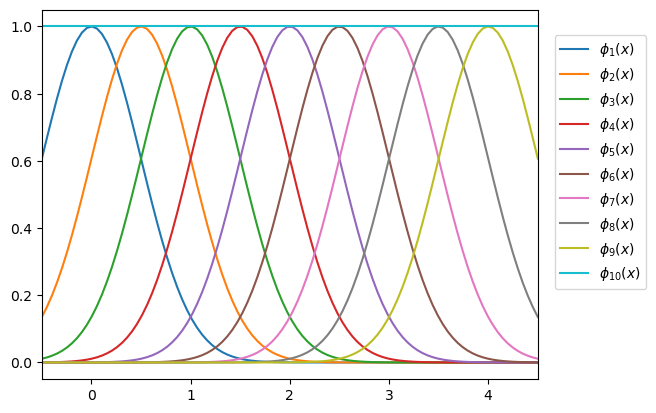

In [34]:
x = np.linspace(-0.5,4.5,100)
mu = np.linspace(0,4,9)
sigma = 0.5
for mu_ in mu:
    plt.plot(x, np.exp(-(x-mu_)**2 / (2*sigma**2)))
plt.plot([-0.5,4.5], [1,1])
plt.xlim([-0.5,4.5])
plt.legend([r"$\phi_{" + str(j+1) + "}(x)$" for j in range(10)], bbox_to_anchor=(1.02,0.95))
plt.show()

In a two-dimensional space, this looks like a mountain-range (when you use hiking maps with contour lines) from above:

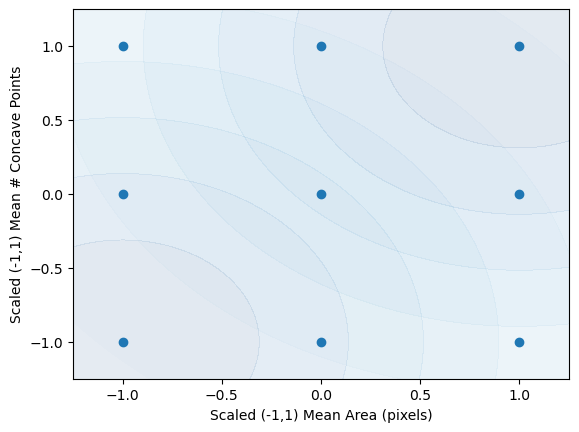

In [35]:
d = 3
sig = d/2

fig, ax = plt.subplots()

XY = np.meshgrid(np.linspace(-1,1,d), np.linspace(-1,1,d))
mu = np.array([XY[0].ravel(), XY[1].ravel()]).T

XX,YY = np.meshgrid(np.linspace(-1.25,1.25,100), np.linspace(-1.25,1.25,100))
# sig = 0.25
for mu_ in [mu[0], mu[-1]]: # we only visualize the top-right and bottom-left for visibility
    ZZ = np.exp(-((XX-mu_[0])**2 + (YY-mu_[1])**2)/(2*sig**2))
    plt.contourf(XX,YY,ZZ, alpha=.1, cmap='Blues')
plt.scatter(mu[:,0], mu[:,1])

ax.set_ylabel('Scaled (-1,1) Mean # Concave Points')
ax.set_xlabel('Scaled (-1,1) Mean Area (pixels)')
plt.show()

The goal of non-linear fitting with RBFs is to approximate the underlying function with a linear combination of these features. By combining them in the proper manner, it is possible to approximate very general functions.

Note also that there is no need to normalize the data, because the RBF features will always be scaled to be between zero and one (we could further normalize the generated features themselves, but this is typically not needed, as the features by definition will already be scaled to the range $[0,1]$).

0.9156414762741653


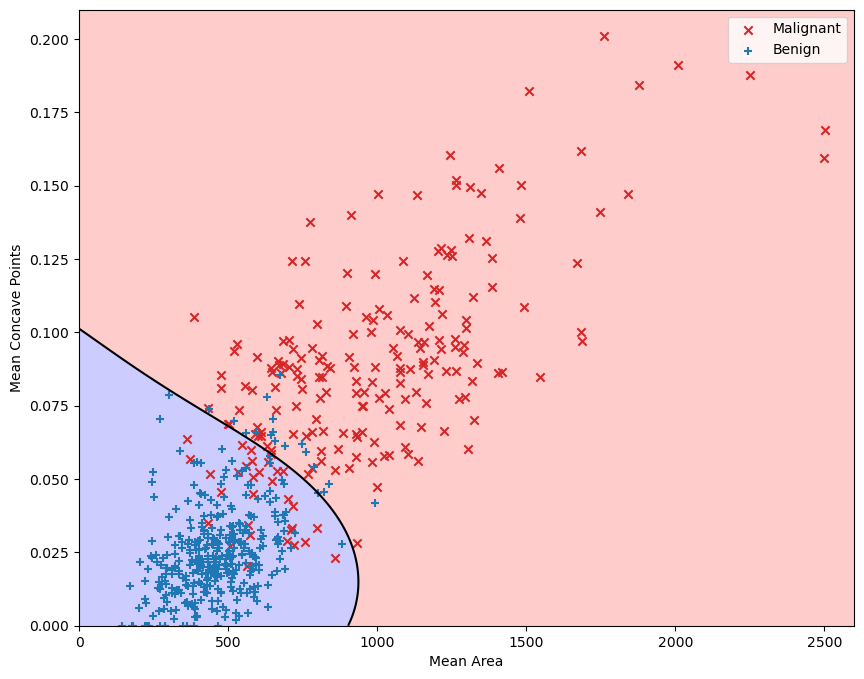

In [36]:
gamma = 1 / (len(X_norm) * X_norm.var()) # scikit-learn uses gamma = 1/(n_features*X.var()) parameterization
model_rbf = SVC(kernel='rbf', C=10.0, gamma=100*gamma)
model_rbf.fit(X_norm, Y)
plot_classification_sklearn(model_rbf, norm)
print(accuracy_score(Y,model_rbf.predict(X_norm)))

And finally, because all these example admittedly look fairly similar (the decision boundary _is_ roughly linear with some noise, after all), let's consider a case where we make the bandwidth small enough so that the method is guaranteed to overfit to the training data. Here we make the bandwidth very small (i.e., $\gamma$ large), and the regularization small, so that the classifier actually manages to get almost 100% accuracy on the training data (of course with very poor generalization performance).

0.9929701230228472


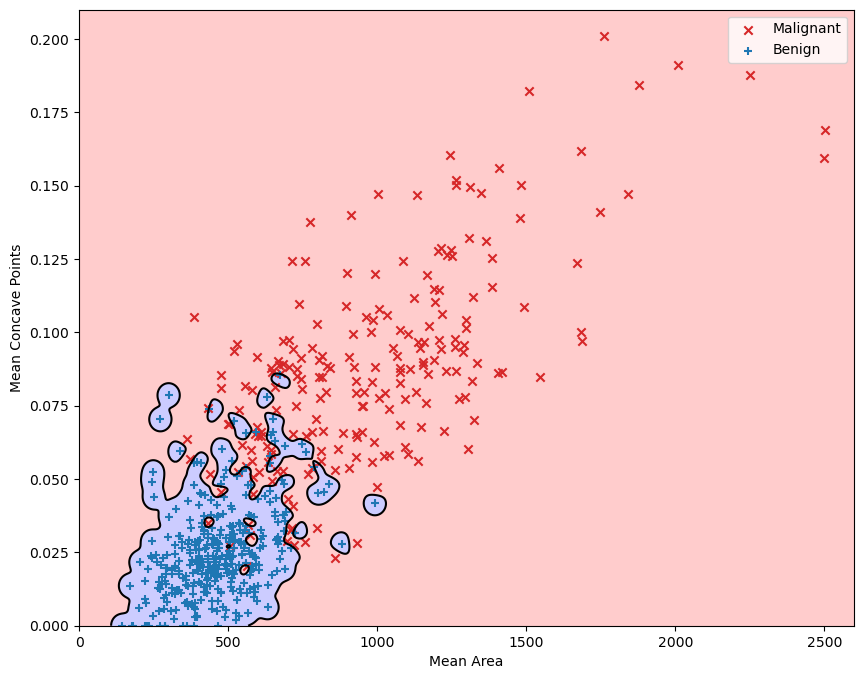

In [37]:
gamma = 1 / (len(X_norm) * X_norm.var()) # scikit-learn uses gamma = 1/(n_features*X.var()) parameterization
model_rbf = SVC(kernel='rbf', C=10.0, gamma=100000*gamma)
model_rbf.fit(X_norm, Y)
plot_classification_sklearn(model_rbf, norm)
print(accuracy_score(Y,model_rbf.predict(X_norm)))

The important thing to keep in mind through all this is how the non-linear features and hyperparameter settings will influence the ability of functions to represent complex data and to overfit and underfit the data. And, of course, when using scikit-learn, you'll need to understand the documentation to the point where you see how the hyperparameters of the class of interest map to the parameters that you actually want to control. This usually requires studying the documentation quite a bit, but it's important, and the default parameters are often quite poor.

---

## Full Implementation with Proper Cross-Validation

The above implementations have been exclusively designed to illustrate the workings of relevant classification algorithms. One issue with that is that we have trained our algorithms on the full set of available data. The classification metrics are, therefore, relatively meaningless as we need to evaluate on previously unseen data. The following code showcases a more realistic model development routine to train a high-performing classification algorithm for the breast cancer dataset.

Let's define some helper functions first. First, we want to know how the model performs, but sometimes without test set performance:

In [38]:
def score_model(model, norm=None, test = False):
    if norm is not None:
        X_train_norm = norm.fit_transform(X_train[:,0:2])
        X_val_norm = norm.fit_transform(X_val[:,0:2])
        X_test_norm = norm.fit_transform(X_test[:,0:2])
    else:
        X_train_norm = X_train[:,0:2]
        X_val_norm = X_val[:,0:2]
        X_test_norm = X_test[:,0:2]
    
    print(f'Training accuracy: {accuracy_score(y_train, model.predict(X_train_norm))}')
    print(f'Validation accuracy: {accuracy_score(y_val, model.predict(X_val_norm))}')
    print(f'Test accuracy: {accuracy_score(y_test, model.predict(X_test_norm))}') if test else None

Then, we define a helper function that wraps most of the usual steps and visually compares how the different sets perform on the fitted decision boundary:

In [39]:
def aio_helper(x1, x2, model, norm=None, test=False):
    if norm is not None:
        X_norm = norm.fit_transform(X_train[:,0:2])
    else:
        X_norm = X_train[:,0:2]
    
    model.fit(X_norm, y_train) # drop ID from features
    
    # look how we did:
    score_model(model, norm=norm, test = test)

    x_range = [cancer_df[x1].min()-(cancer_df[x1].mean()*0.1), cancer_df[x1].max()+(cancer_df[x1].mean()*0.1)]
    y_range = [cancer_df[x2].min()-(cancer_df[x2].mean()*0.1), cancer_df[x2].max()+(cancer_df[x2].mean()*0.1)]

    # set up plotting
    fig, ax = plt.subplots(1,3 if test else 2, figsize=(13,5))
    
    # plot classifcation regions
    grid=1000
    xx,yy = np.meshgrid(np.linspace(x_range[0], x_range[1], grid),
                        np.linspace(y_range[0], y_range[1], grid))
    X_ = np.array([np.ravel(xx), np.ravel(yy)]).T
    if not norm is None:
        zz = model.decision_function(norm.transform(X_)).reshape(grid,grid)
    else:
        zz = model.decision_function(X_).reshape(xx.shape)

    for i in range(3 if test else 2):
        ax[i].imshow(
            zz,
            interpolation="nearest",
            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
            aspect="auto",
            alpha=0.5,
            origin="lower",
            cmap='rocket_r',
        )
        # cs = plt.contourf(xx,yy,zz, zz,levels=[-float("inf"),0,float("inf")],alpha=0.2,colors=["b","r"])
        # plt.contour(cs, colors='k')

    # plot data points
    sns.scatterplot(ax=ax[0], x=X_train[:,0], y=X_train[:,1], hue=y_train,
                    style=y_train, markers={'M': 'X', 'B': 'o'}, 
                    palette='rocket', hue_order=['M', 'B'])
    ax[0].set_title('Training Data')
    ax[0].set_xlabel(features[0])
    ax[0].set_ylabel(features[1])

    sns.scatterplot(ax=ax[1], x=X_val[:,0], y=X_val[:,1], hue=y_val,
                    style=y_val, markers={'M': 'X', 'B': 'o'}, 
                    palette='rocket', hue_order=['M', 'B'])
    ax[1].set_title('Validation Data')
    ax[1].set_xlabel(features[0])
    ax[1].set_ylabel(features[1])

    if test:
        sns.scatterplot(ax=ax[2], x=X_test[:,0], y=X_test[:,1], hue=y_test,
                        style=y_test, markers={'M': 'X', 'B': 'o'}, 
                        palette='rocket', hue_order=['M', 'B'])
        ax[2].set_title('Test Data')
        ax[2].set_xlabel(features[0])
        ax[2].set_ylabel(features[1])
    # s1 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='M'][x1], cancer_df[cancer_df["diagnosis"]=='M'][x2], marker='x', color='C3')
    # s2 = plt.scatter(cancer_df[cancer_df["diagnosis"]=='B'][x1], cancer_df[cancer_df["diagnosis"]=='B'][x2], marker='+', color='C0')    
    # plt.xlim(x_range)
    # plt.ylim(y_range)
    # plt.xlabel(x1)
    # plt.ylabel(x2)
    # plt.legend([s1,s2],['Malignant','Benign'])

    plt.show()

Finally, we use the defined functions:

Training accuracy: 0.718475073313783
Validation accuracy: 0.7543859649122807


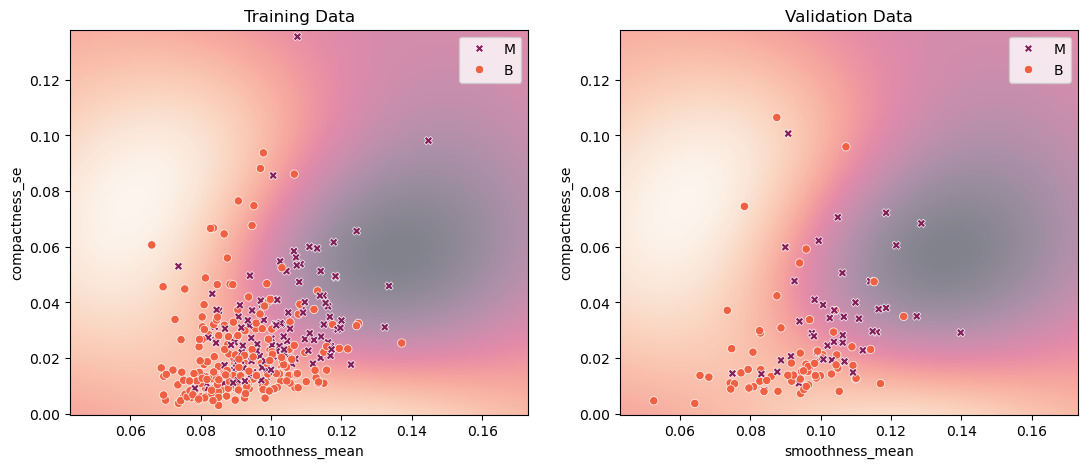

In [40]:
# Imports
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import pandas as pd

# Config
features = ('smoothness_mean','compactness_se', 'id') # we keep the ID around for plotting the different sets

# Read in the data set and choose features to use
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
cancer_df.reset_index(inplace=True)
X = np.array(cancer_df[[*features]])
Y = cancer_df['diagnosis'].values

# split the data set for cross-validation
X_train, X_, y_train, y_ = train_test_split(X, Y, train_size = 0.6)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5)

# fit a model with RBF features (kernel)
model = SVC(kernel='rbf')

# do a first run without scaling and hyperparameter tuning
aio_helper(*features[:2], model, norm=None, test=False)

Well, we see that the two features we chose have one problem: They make for no good decision boundaries. So let's try some other features!

Training accuracy: 0.9149560117302052
Validation accuracy: 0.9473684210526315


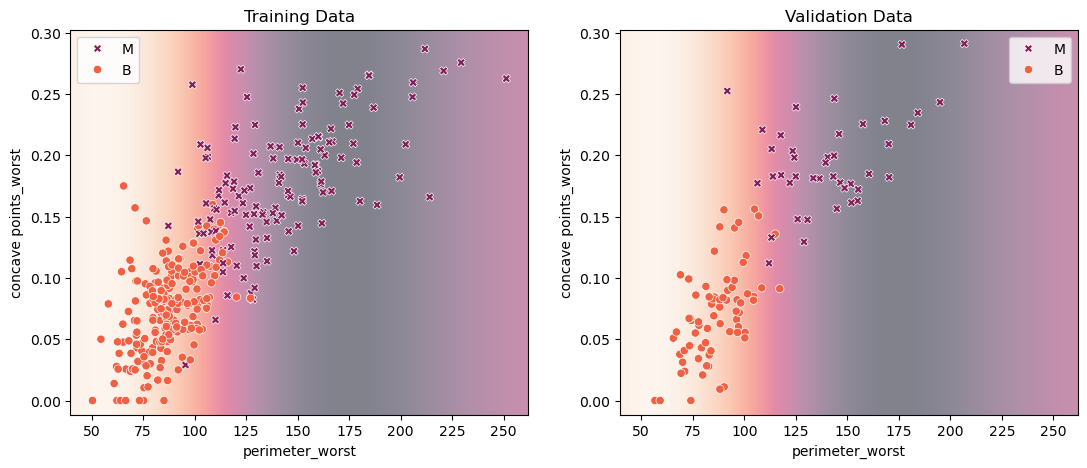

In [41]:
# Config
features = ('perimeter_worst','concave points_worst', 'id') # we keep the ID around for plotting the different sets

# Read in the data set and choose features to use
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
cancer_df.reset_index(inplace=True)
X = np.array(cancer_df[[*features]])
Y = cancer_df['diagnosis'].values

# split the data set for cross-validation
X_train, X_, y_train, y_ = train_test_split(X, Y, train_size = 0.6)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5)

# fit a model with RBF features (kernel)
model = SVC(kernel='rbf')

# do a first run without scaling and hyperparameter tuning
aio_helper(*features[:2], model, norm=None, test=False)

Well, this got us a linear decision boundary - even though we were using RBFs... How is that possible?
The answer lies in the scales of the dimensions: The decision boundary is basically only dictated by changes in x1 (`perimeter_worst`).
Let's introduce scaling to alleviate that.

Training accuracy: 0.9354838709677419
Validation accuracy: 0.8947368421052632


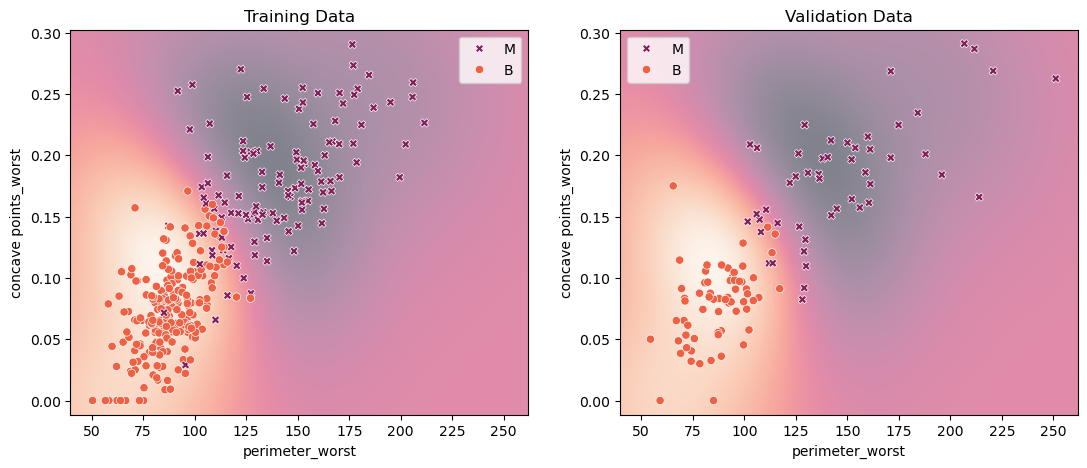

In [42]:
# Config
features = ('perimeter_worst','concave points_worst', 'id') # we keep the ID around for plotting the different sets

# Read in the data set and choose features to use
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
cancer_df.reset_index(inplace=True)
X = np.array(cancer_df[[*features]])
Y = cancer_df['diagnosis'].values

# split the data set for cross-validation
X_train, X_, y_train, y_ = train_test_split(X, Y, train_size = 0.6)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5)

# fit a model with RBF features (kernel)
model = SVC(kernel='rbf')

# do a first run without scaling and hyperparameter tuning
aio_helper(*features[:2], model, norm=StandardScaler(), test=False)

Even though we managed to get the scaling right and the scores a little higher, this looks overly regularized...

Training accuracy: 0.9618768328445748
Validation accuracy: 0.9298245614035088


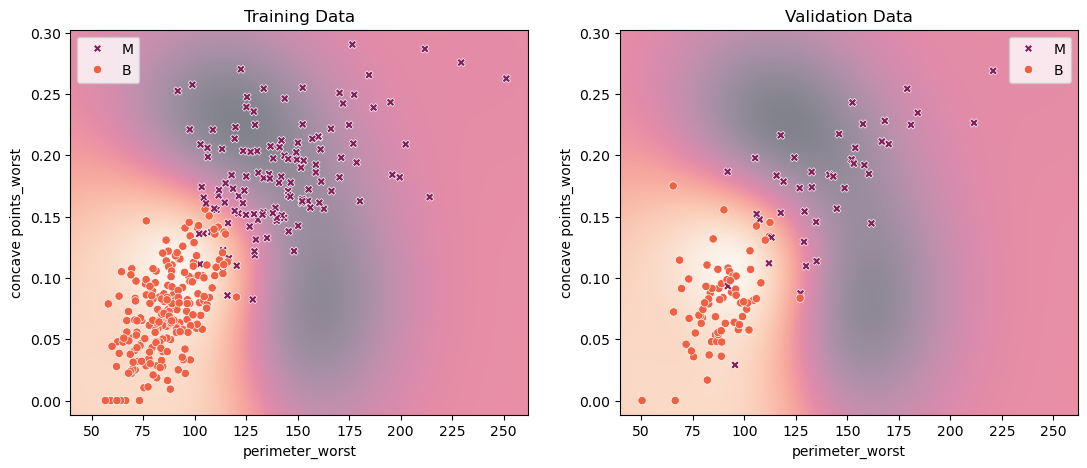

In [43]:
# Config
features = ('perimeter_worst','concave points_worst', 'id') # we keep the ID around for plotting the different sets

# Read in the data set and choose features to use
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
cancer_df.reset_index(inplace=True)
X = np.array(cancer_df[[*features]])
Y = cancer_df['diagnosis'].values

# split the data set for cross-validation
X_train, X_, y_train, y_ = train_test_split(X, Y, train_size = 0.6)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5)

# fit a model with RBF features (kernel) and less strict regularization
# hint: with sklearn SVM the C parameter is inversely proportional to regularization strength!
model = SVC(kernel='rbf', C=10)

# do a first run without scaling and hyperparameter tuning
aio_helper(*features[:2], model, norm=StandardScaler(), test=False)

Okay, we like this, so let's repeat this, but this time let's look at the test score!

Training accuracy: 0.9413489736070382
Validation accuracy: 0.9473684210526315
Test accuracy: 0.9473684210526315


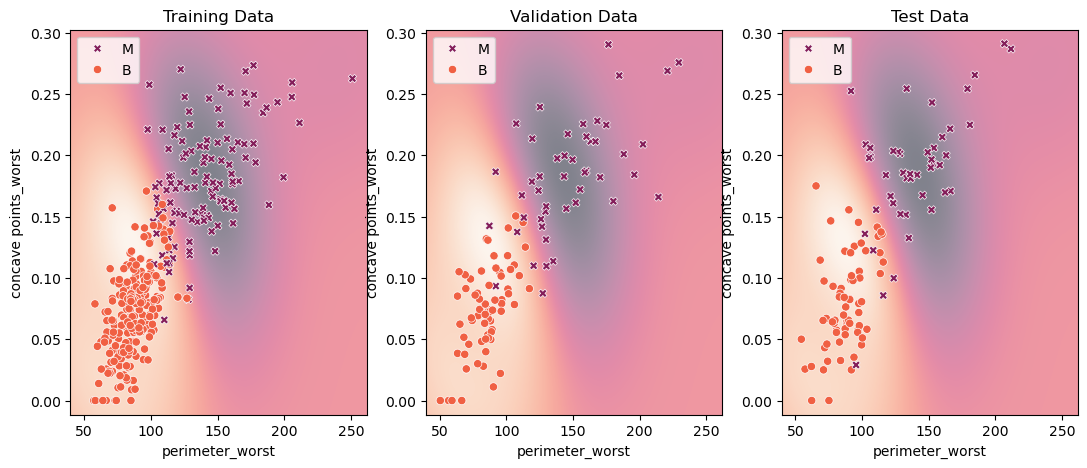

In [44]:
# Config
features = ('perimeter_worst','concave points_worst', 'id') # we keep the ID around for plotting the different sets

# Read in the data set and choose features to use
cancer_df = pd.read_csv("../data/breast_cancer.csv", index_col = "id")
cancer_df.reset_index(inplace=True)
X = np.array(cancer_df[[*features]])
Y = cancer_df['diagnosis'].values

# split the data set for cross-validation
X_train, X_, y_train, y_ = train_test_split(X, Y, train_size = 0.6)
X_val, X_test, y_val, y_test = train_test_split(X_, y_, test_size = 0.5)

# fit a model with RBF features (kernel) and less strict regularization
# hint: with sklearn SVM the C parameter is inversely proportional to regularization strength!
model = SVC(kernel='rbf', C=10)

# do a first run without scaling and hyperparameter tuning
aio_helper(*features[:2], model, norm=StandardScaler(), test=True)

Test score looks good! Doesn't indicate overfitting to either the training data or the hyperparameters!
(Note: In reality, we would've wanted to re-train the model using training and validation data mixed to compute the test scores!)

How was I able to come up with two features that can achieve 95% accuracy? See below!

In [45]:
from sklearn.feature_selection import SelectKBest, f_classif

X_new = SelectKBest(f_classif, k=2).fit_transform(np.array(cancer_df.drop(columns=['diagnosis'])), Y) 

---